*First compiled: May 3, 2017.*

### Profiling Scanpy  for 68k PBMC cells of [Zheng *et al.*, Nat. Comm. (2017)](https://doi.org/10.1038/ncomms14049)

This is the *Scanpy* benchmark for the *Cell Ranger* R analysis of [Zheng *et al.*, Nat. Comms. (2017)](https://doi.org/10.1038/ncomms14049) available from https://github.com/10XGenomics/single-cell-3prime-paper. Compare the Scanpy version with the [Cell Ranger version of this notebook](zheng17_pbmc64k_cellranger_r.ipynb).

The data is freely available [[page](https://support.10xgenomics.com/single-cell/datasets/fresh_68k_pbmc_donor_a)/[file](https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/fresh_68k_pbmc_donor_a/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices.tar.gz)] from the 10x homepage and from [GitHub](https://github.com/10XGenomics/single-cell-3prime-paper).

In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 0                # increase for more output
sc.settings.set_dpi(80)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2 on 2017-07-24 01:42.


Initial usage of memory.

In [3]:
sc.logging.print_memory_usage()

Memory usage: current 0.12 GB, difference +0.12 GB


Only use the first n cells, set to 0 if you want all cells.

In [4]:
use_first_n_samples = None

Set the file paths.

In [5]:
filename_data = './data/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices/hg19/matrix.mtx'
filename_genes = './data/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices/hg19/genes.tsv'
filename_barcodes = './data/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices/hg19/barcodes.tsv'

Load the data. This takes a long time only when first reading the raw data from the `.mtx` text file. It's very fast after that.

In [6]:
%%time
adata = sc.read(filename_data, cache=True).transpose()
adata.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
adata.smp_names = np.genfromtxt(filename_barcodes, dtype=str)
sc.logging.print_memory_usage()

Memory usage: current 0.42 GB, difference +0.30 GB
CPU times: user 2.03 s, sys: 573 ms, total: 2.61 s
Wall time: 2.68 s


Reduce the number of samples for scaling information.

In [7]:
if use_first_n_samples != 0:
    adata = adata[:use_first_n_samples]

Save the logarithmized raw data for differential expression testing.

In [8]:
sc.write('zheng17_raw_log', sc.pp.log1p(adata, copy=True))

Compute the fraction of mitochondrial genes for later use.

In [9]:
mito_genes = np.array([name for name in adata.var_names if name.startswith('MT-')])
# for each cell compute fraction of counts in mito genes vs. all genes
adata.smp['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

### Preprocessing

Instead of calling all steps of this preprocessing section separtely, you can call    

[`sc.pp.recipe_zheng17(adata)`](https://github.com/theislab/scanpy/blob/a2a330fa4640fdd4847fb48970a743242936e1df/scanpy/preprocessing/recipes.py#L58-L73)   

and continue directly with the computation of the PCA. 

Per-cell normalize the data matrix $X$ and identify highly-variable genes. 

In [10]:
%%time
sc.pp.filter_genes(adata, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell
filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 1.00 GB, difference +0.58 GB
CPU times: user 2.31 s, sys: 1.06 s, total: 3.37 s
Wall time: 3.44 s


Plot the dispersion relation. Use a logarithmic scale as the data is not yet logarithmized.

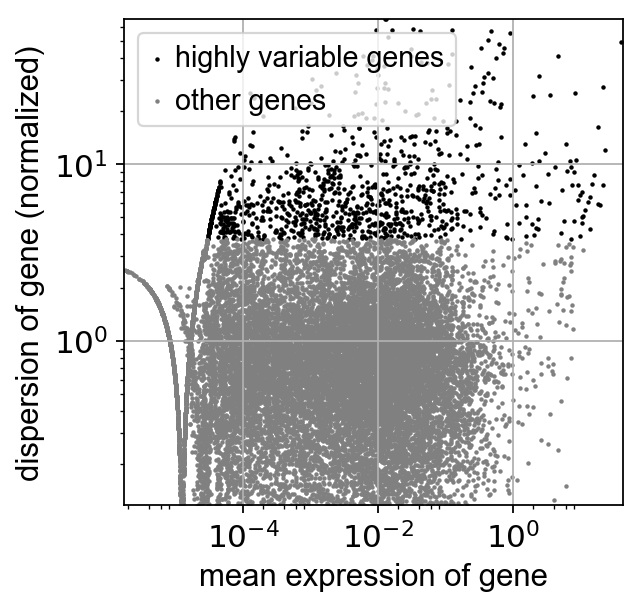

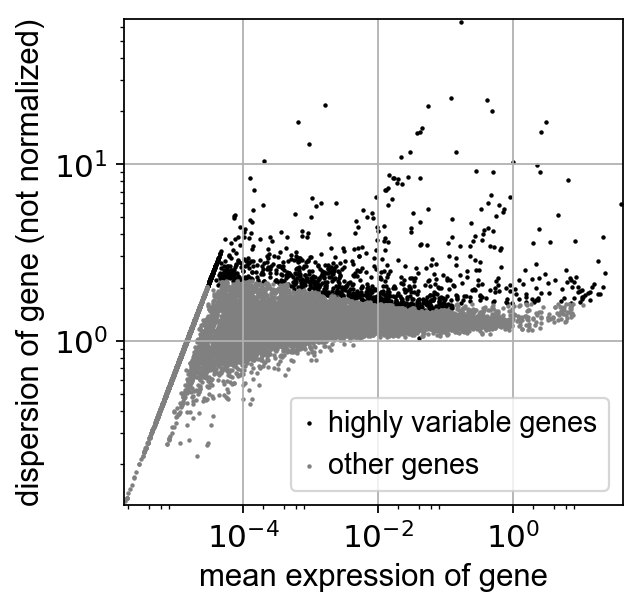

In [11]:
sc.pl.filter_genes_dispersion(filter_result, log=True)

Normalize the data again, logarithmize and scale the data. Then compute the PCA.

In [12]:
%%time
adata = adata[:, filter_result.gene_subset]  # filter genes
sc.pp.normalize_per_cell(adata)  # need to redo normalization after filtering
sc.pp.log1p(adata)  # log transform: X = log(X + 1)
sc.pp.scale(adata)
# here, we continue with the computation of the PCA, 
# to be able to compare with Cell Ranger
# the PCA is *not* contained in the recipe sc.pp.recipe_zheng17(adata)
sc.tl.pca(adata, n_comps=50)
sc.logging.print_memory_usage()

Memory usage: current 0.47 GB, difference -0.53 GB
CPU times: user 18 s, sys: 1.61 s, total: 19.7 s
Wall time: 15.9 s


Plot the PCA results.

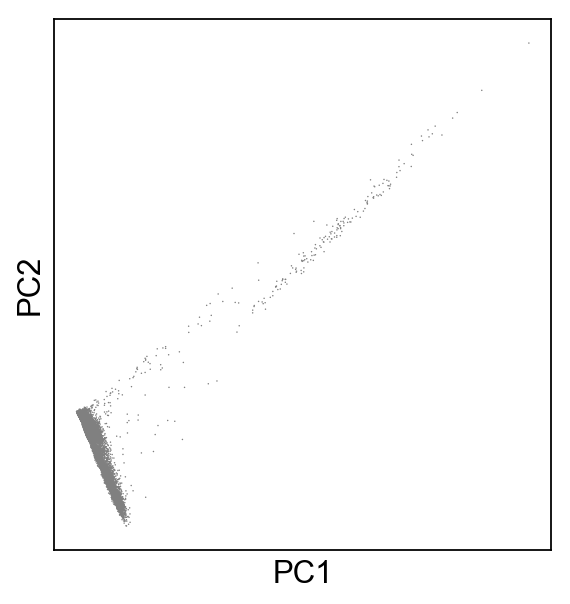

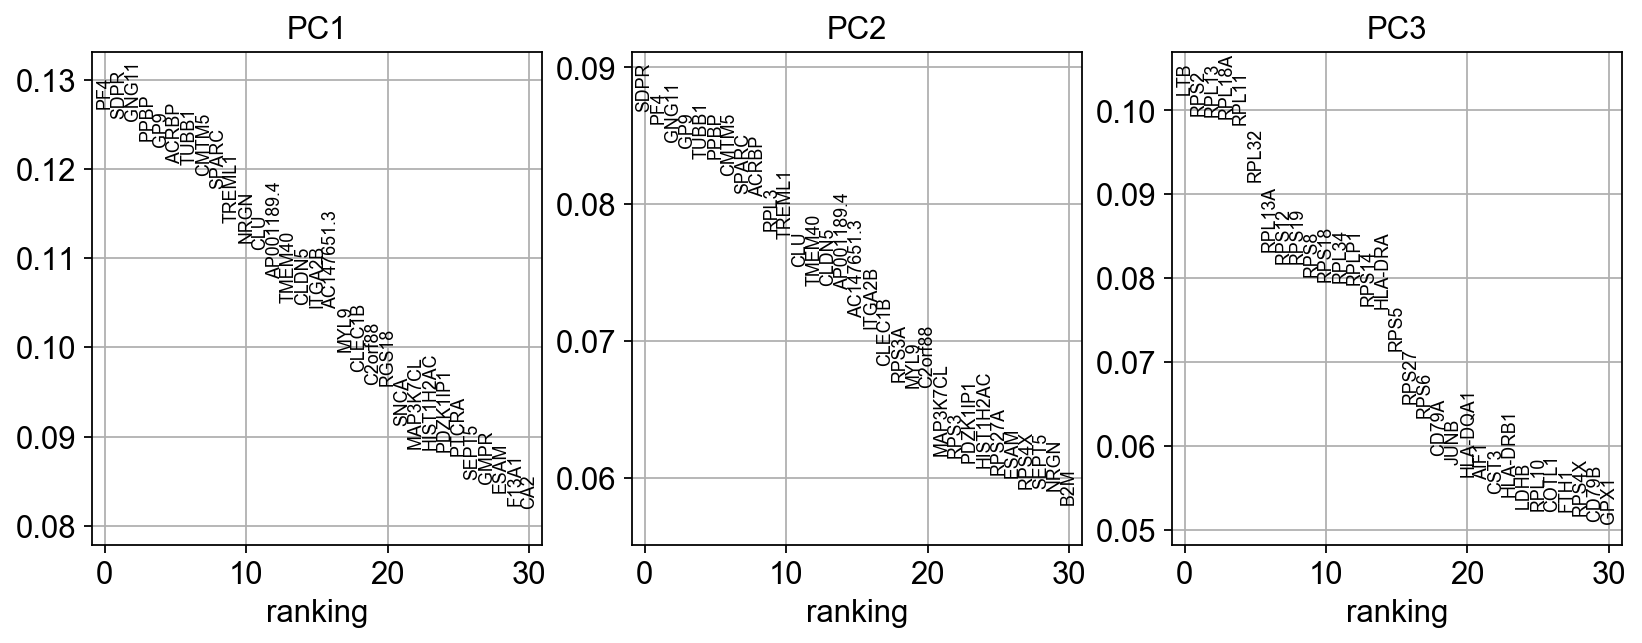

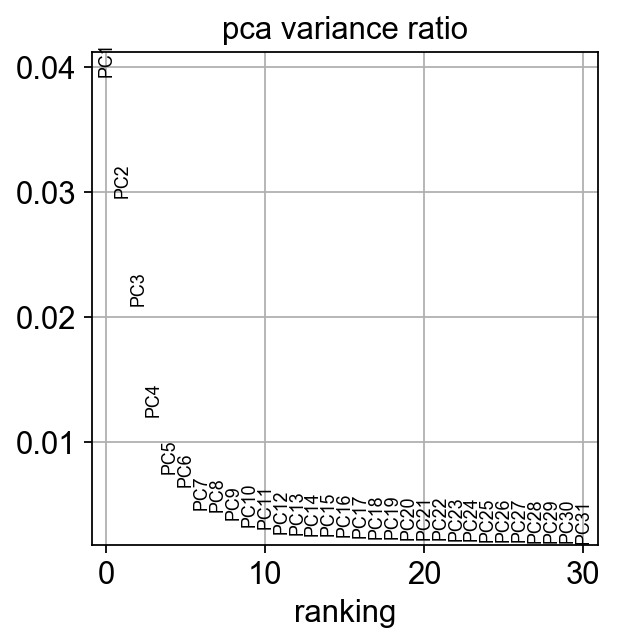

In [13]:
sc.pl.pca(adata)

Save the result.

In [14]:
sc.write('zheng17', adata)

### tSNE

Compute tSNE. This can, even on a single core, be sped up significantly by installing https://github.com/DmitryUlyanov/Multicore-TSNE, which is automatically detected by Scanpy.

In [15]:
%%time
sc.tl.tsne(adata)
sc.logging.print_memory_usage()

Memory usage: current 0.52 GB, difference +0.05 GB
CPU times: user 7min 14s, sys: 15.8 s, total: 7min 29s
Wall time: 5min 32s


Save the result.

In [16]:
sc.write('zheng17', adata)

Let us use the cell type labels generated by Zheng *et al.* by correlating gene expression with purified bulk data. You can download the cell groups here [./data/PBMC68k.cellLables.txt](./data/PBMC68k.cellLables.txt).

In [17]:
adata = sc.read('zheng17')

In [18]:
filename_labels = './data/PBMC68k.cellLables.txt'
bulk_labels = np.genfromtxt(filename_labels, delimiter='\t', dtype=str)
adata.smp['bulk_labels'] = bulk_labels[:adata.n_smps]
sc.write('zheng17', adata)

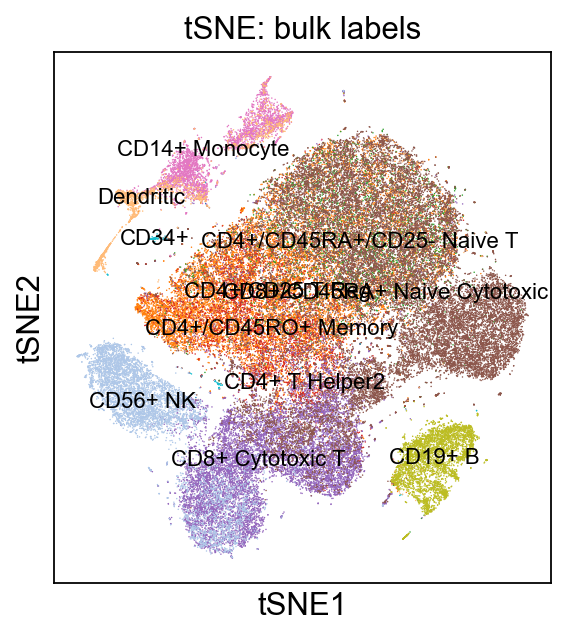

In [15]:
axs = sc.pl.tsne(adata, color='bulk_labels', legend_loc='on data', legend_fontsize=10, title='tSNE: bulk labels')

### Clustering

In [20]:
adata = sc.read('zheng17')

Instead of providing a simple k means clustering as in Cell Ranger, we use the Louvain algorithm of [Blondel *et al.* (2008)](https://doi.org/10.1088/1742-5468/2008/10/P10008), as suggested by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.047) for single-cell analysis.

In [21]:
%%time
sc.tl.louvain(adata, resolution=1.2)
sc.logging.print_memory_usage()

Memory usage: current 0.34 GB, difference -0.18 GB
CPU times: user 2min 15s, sys: 37.6 s, total: 2min 53s
Wall time: 2min 13s


Save the results.

In [22]:
sc.write('zheng17', adata)

Plot the clusters.

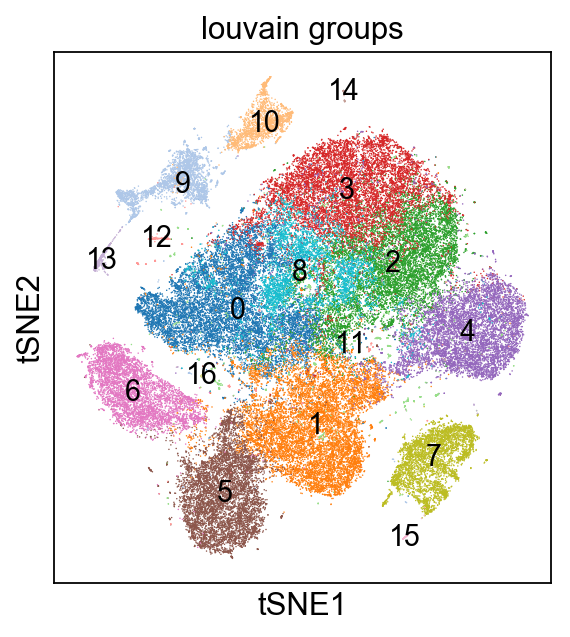

In [23]:
adata = sc.read('zheng17')
axs = sc.pl.tsne(adata, color=['louvain_groups'], legend_loc='on data')

### Marker Genes

Use the logarithmized raw data to rank genes according to differential expression.

In [24]:
%%time
adata = sc.read('zheng17')
adata_raw = sc.read('zheng17_raw_log')
adata_raw.smp['louvain_groups'] = adata.smp['louvain_groups']
sc.tl.rank_genes_groups(adata_raw, 'louvain_groups',
                        groups=[1, 6, 9, 7])
sc.logging.print_memory_usage()

Memory usage: current 1.38 GB, difference +1.04 GB
CPU times: user 7.75 s, sys: 4.1 s, total: 11.9 s
Wall time: 12.3 s


Save the result.

In [25]:
sc.write('zheng17_raw_log', adata_raw)

Plot the result.

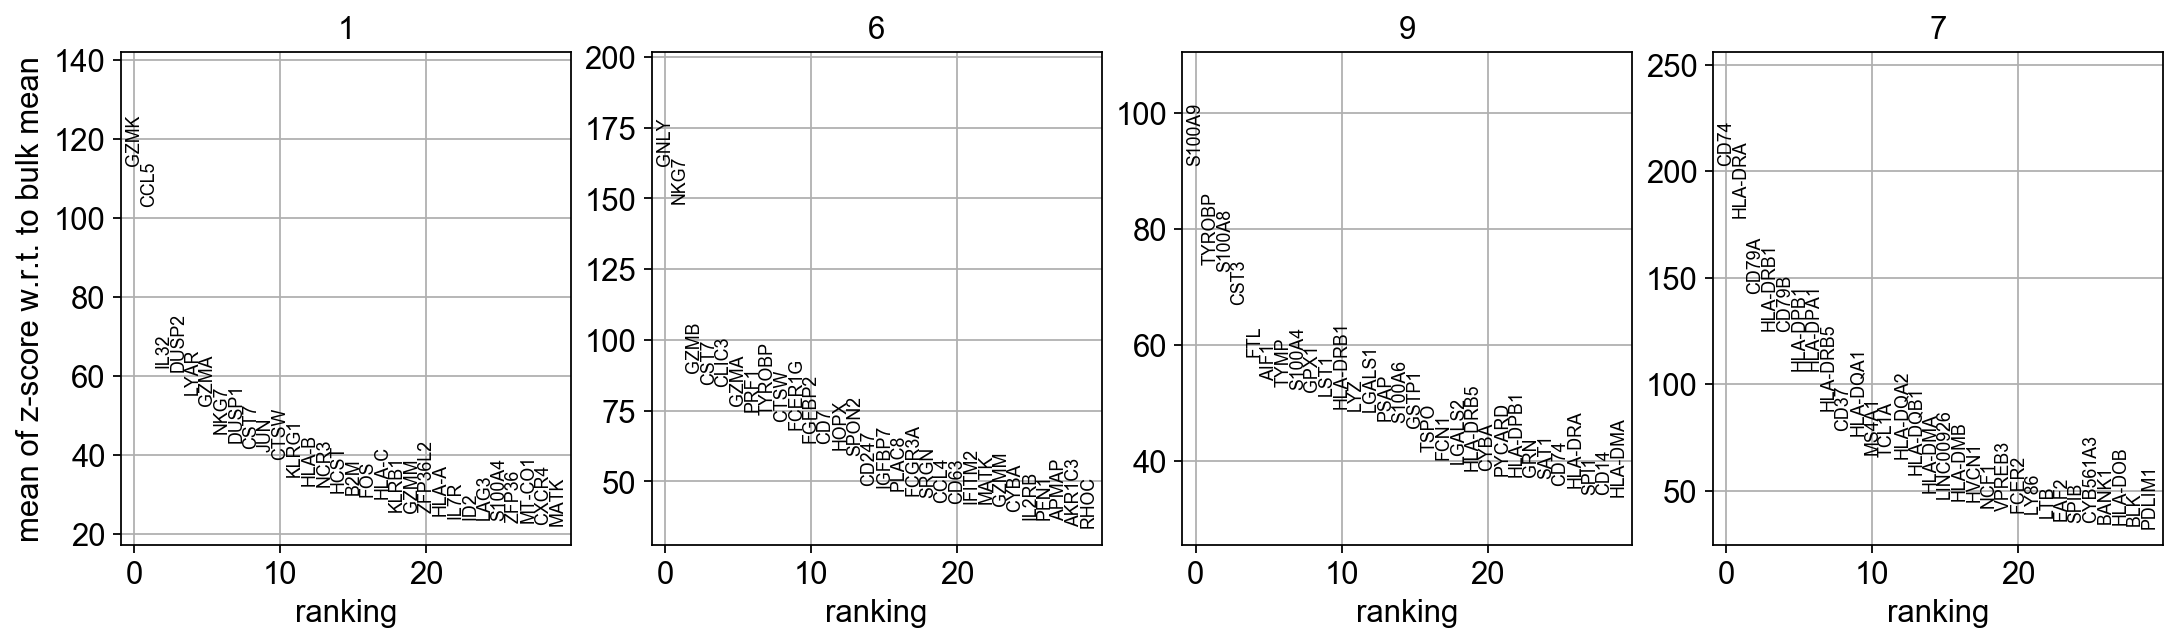

In [2]:
adata_raw = sc.read('zheng17_raw_log')
sc.pl.rank_genes_groups(adata_raw, n_genes=30)

Cluster '1' shows the marker IL7R for CD4 T-cells at 22.

Cluster '6' shows the marker NKG7 for NK cells.

Cluster '9' shows the marker CD14 for CD14+ Monocytes at rank 29.

Cluster '7' shows the B cell marker MS4A1 at rank 10. Etc.

Plot the distribution of identified markers for all clusters.

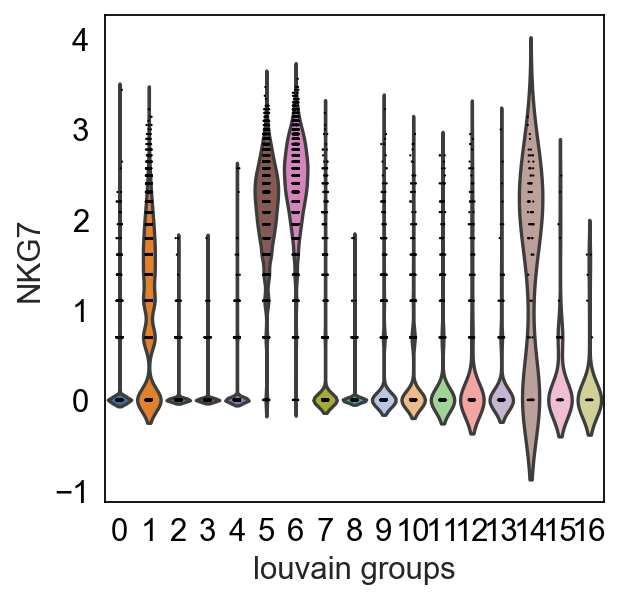

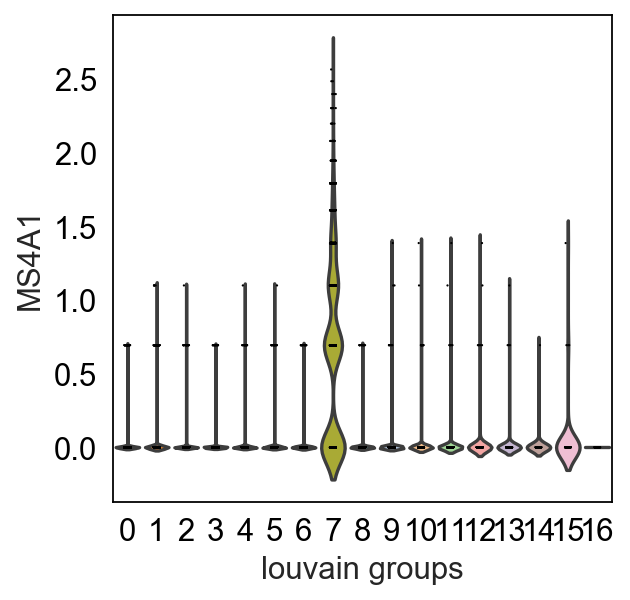

In [3]:
ax = sc.pl.violin(adata_raw, 'NKG7', group_by='louvain_groups')
ax = sc.pl.violin(adata_raw, 'MS4A1', group_by='louvain_groups')

### Diffusion Maps and Diffusion Pseudotime

In [28]:
adata = sc.read('zheng17')

In [29]:
%%time
sc.tl.diffmap(adata)
sc.logging.print_memory_usage()

Memory usage: current 0.95 GB, difference -0.42 GB
CPU times: user 2min 18s, sys: 36.2 s, total: 2min 54s
Wall time: 2min 3s


In [33]:
sc.write('zheng17', adata)

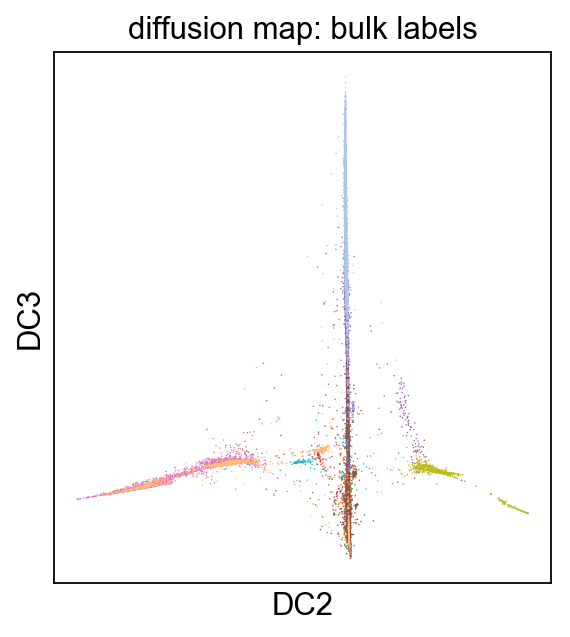

In [6]:
adata = sc.read('zheng17')
ax = sc.pl.diffmap(adata, components='2,3',
                   color='bulk_labels', legend_loc='none', right_margin=0.5,
                   legend_fontsize=5, title='diffusion map: bulk labels')

To compute the pseudotime, add a "root" cell, a reference sample from which to compute the random-walk based distance "DPT" [(Haghveri *et al.*, (2017)](https://doi.org/10.1038/nmeth.3971).

In [10]:
adata.add['iroot'] = np.flatnonzero(adata.smp['bulk_labels'] == 'CD34+')[0]

In [11]:
%%time
sc.tl.dpt(adata)
sc.logging.print_memory_usage()

Memory usage: current 0.58 GB, difference -0.19 GB
CPU times: user 415 ms, sys: 103 ms, total: 517 ms
Wall time: 530 ms


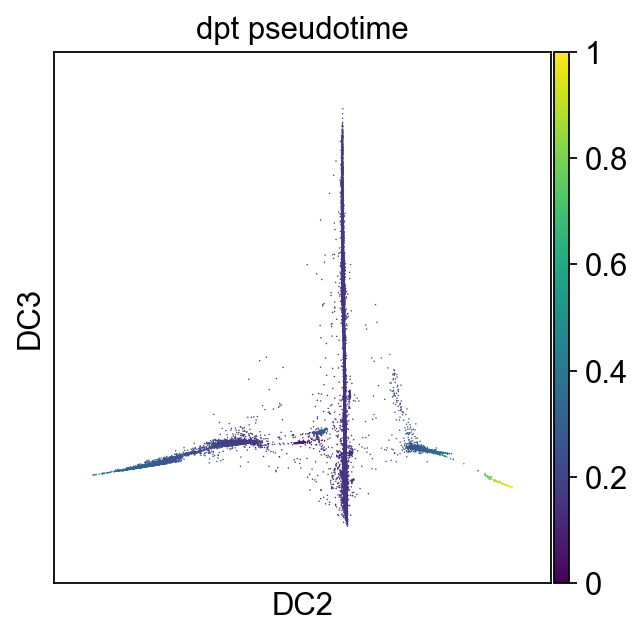

In [12]:
ax = sc.pl.diffmap(adata, color='dpt_pseudotime', components='2,3')

### Force-directed graph-drawing

Further visualizations are always helpful. For the graph drawing layout 'fr' though, we should subsample to speed up the computations.

In [49]:
adata = sc.read('zheng17')
adata_sub = sc.pp.subsample(adata, fraction=0.5, copy=True)

In [50]:
%%time
sc.tl.draw_graph(adata_sub, layout='fr', recompute_graph=True)
sc.logging.print_memory_usage()

Memory usage: current 1.43 GB, difference +0.17 GB
CPU times: user 2h 12min 59s, sys: 59 s, total: 2h 13min 58s
Wall time: 2h 18min


In [ ]:
sc.write('zheng17_fr', adata_sub)

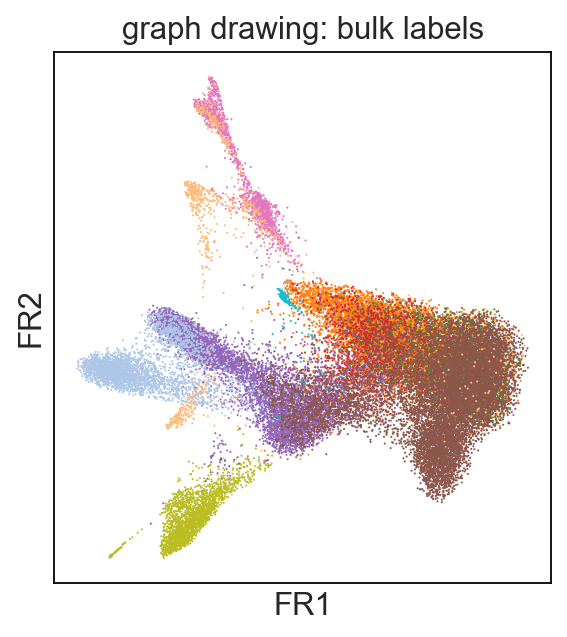

In [11]:
adata_sub = sc.read('zheng17_fr')
ax = sc.pl.draw_graph(adata_sub, color='bulk_labels', legend_fontsize=9, legend_loc='none',
                      title='graph drawing: bulk labels')

### Regressing out total counts and mitochondrial genes

It is often helpful to regress out the total counts. See Seurat's [clustering tutorial](http://satijalab.org/seurat/pbmc-tutorial.html) or the [Scanpy version](https://github.com/theislab/scanpy_usage/tree/master/170505_seurat) of it.

In [16]:
adata = sc.read('zheng17')

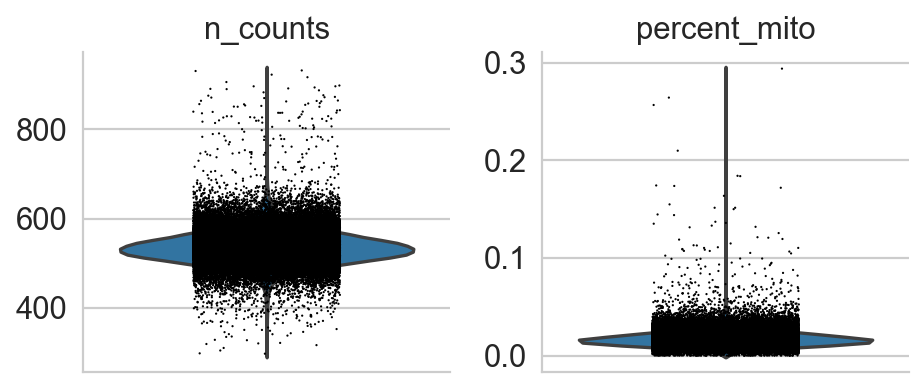

In [17]:
ax = sc.pl.violin(adata, ['n_counts', 'percent_mito'],
                  jitter=0.2, multi_panel=True)

In [44]:
adata_sub = sc.pp.subsample(adata, fraction=0.05, copy=True)

Instead of 'n_counts', you can add multiple sample annotation keys here; e.g., also a batch variable.

In [45]:
%%time
adata_corrected = sc.pp.regress_out(adata_sub, 'n_counts',
                                    copy=True)
sc.logging.print_memory_usage()


Memory usage: current 1.26 GB, difference -0.08 GB
CPU times: user 1.69 s, sys: 299 ms, total: 1.98 s
Wall time: 3.87 s


In [46]:
sc.write('zheng17_corrected', adata_corrected)

In [47]:
sc.tl.tsne(adata_corrected)

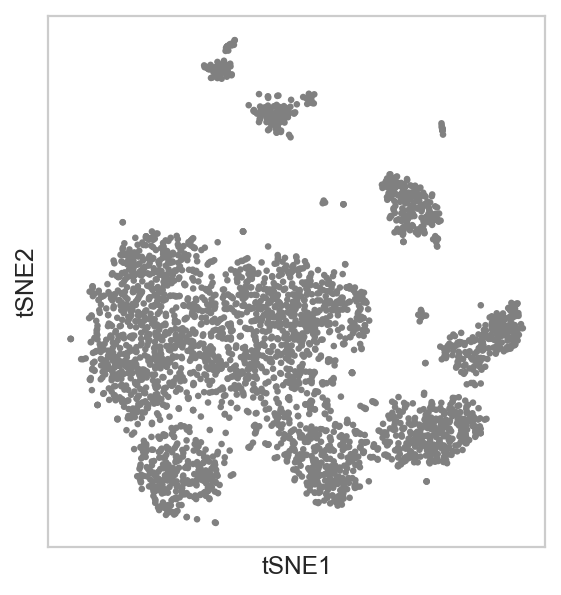

In [48]:
ax = sc.pl.tsne(adata_corrected, color='bulk_labels')